In [147]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
# from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
import cv2
from sklearn.cluster import DBSCAN
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

pose_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_pose/session_pose_info'
os.makedirs(pose_analysis_session_data,exist_ok=True)

case_study_input_data = f'{SERVER_CACHE_DIR}/case_studies_input_raw/'
os.makedirs(case_study_input_data,exist_ok=True)


embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

in_session_median_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_median_embeddings'
os.makedirs(in_session_median_embeddings_data_dir, exist_ok=True)

in_session_cluster_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_cluster_embeddings'
os.makedirs(in_session_cluster_embeddings_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

In [166]:
session_filter_list = [
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
]

results_dir = f'results/20231120'
os.makedirs(results_dir, exist_ok=True)

In [167]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]        
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [168]:
def frame_to_timestamp(frameNumber):
    return pd.to_timedelta(int(frameNumber*1000/15),unit='ms')

In [169]:
handraise_dfs = []
hand_positions = {'other':0, 'error':0, 'handsOnFace':0, 'armsCrossed':0, 'handsRaised':1}
for session_idx, session_id in enumerate(session_filter_list):
    case_study_input_cache_file = f"{case_study_input_data}/{session_id}-front.pb"
    instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))
    ts_data_dfs = []
    sid_idx = 0
    for sid in sorted(list(posture_info.keys())):
        if sid not in instructor_ids:
            handraise_sid = deepcopy(posture_info[sid]).reset_index()
            handraise_sid['time'] = handraise_sid['frame']//(60*15)
            handraise_sid['hand_raised'] = handraise_sid.armPose.apply(lambda x: hand_positions[x])
            handraise_sid = handraise_sid.groupby('time',as_index=False).agg({'hand_raised':lambda x: x.sum()>0})
            handraise_sid = handraise_sid[handraise_sid['hand_raised']==1]
            handraise_sid['StudentID'] = sid_idx
            sid_idx+=1
            handraise_sid = handraise_sid[['StudentID','time','hand_raised']]
            handraise_sid['session'] = session_id
            ts_data_dfs.append(handraise_sid)
    
    df_handraise_session = pd.concat(ts_data_dfs)
    handraise_dfs.append(df_handraise_session)
    print(f"Got session {session_id}")


Got session classinsight-cmu_05748A_ghc_4101_201902141630
Got session classinsight-cmu_05748A_ghc_4101_201904021630



KeyboardInterrupt



In [ ]:
df_handraises = pd.concat(handraise_dfs)
df_handraises.info()
df_handraises.head()

In [170]:
# df_handraises.to_csv(f'{results_dir}/handraise_times.csv',index=False)
df_handraises = pd.read_csv(f'{results_dir}/handraise_times.csv')
df_handraises.info()
df_handraises.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StudentID    1191 non-null   int64 
 1   time         1191 non-null   int64 
 2   hand_raised  1191 non-null   bool  
 3   session      1191 non-null   object
dtypes: bool(1), int64(2), object(1)
memory usage: 29.2+ KB


,StudentID,time,hand_raised,session
0,0,0,True,classinsight-cmu_05748A_ghc_4101_201902141630
1,0,3,True,classinsight-cmu_05748A_ghc_4101_201902141630
2,0,10,True,classinsight-cmu_05748A_ghc_4101_201902141630
3,0,20,True,classinsight-cmu_05748A_ghc_4101_201902141630
4,0,61,True,classinsight-cmu_05748A_ghc_4101_201902141630


# Across Student for 5 students 

In [204]:
course = '17214C'
df_session_hand_raises  = df_handraises.groupby(['session','StudentID'],as_index=False)['time'].count()
df_session_hand_raises = df_session_hand_raises[df_session_hand_raises.session.apply(lambda x: course in x)]
df_session_hand_raises.sort_values(by='time',ascending=False)

,session,StudentID,time
190,classinsight-cmu_17214C_ph_225b_201904241130,7,39
178,classinsight-cmu_17214C_ph_225b_201904171130,9,18
150,classinsight-cmu_17214C_ph_225b_201903201130,7,14
156,classinsight-cmu_17214C_ph_225b_201904101130,2,14
149,classinsight-cmu_17214C_ph_225b_201903201130,6,13
...,...,...,...
182,classinsight-cmu_17214C_ph_225b_201904171130,13,1
185,classinsight-cmu_17214C_ph_225b_201904241130,1,1
165,classinsight-cmu_17214C_ph_225b_201904101130,11,1
189,classinsight-cmu_17214C_ph_225b_201904241130,6,1


In [205]:
df_session_hand_raises.session.unique()

array(['classinsight-cmu_17214C_ph_225b_201903201130',
       'classinsight-cmu_17214C_ph_225b_201904101130',
       'classinsight-cmu_17214C_ph_225b_201904171130',
       'classinsight-cmu_17214C_ph_225b_201904241130',
       'classinsight-cmu_17214C_ph_225b_201905011130'], dtype=object)

In [206]:
df_session_hand_raises['sid'] = df_session_hand_raises.apply(lambda row: f'{row["session"].split("_")[-1][-8:-4]}_{row["StudentID"]}', axis=1)
df_session_hand_raises.head()

,session,StudentID,time,sid
146,classinsight-cmu_17214C_ph_225b_201903201130,0,3,0320_0
147,classinsight-cmu_17214C_ph_225b_201903201130,2,1,0320_2
148,classinsight-cmu_17214C_ph_225b_201903201130,5,2,0320_5
149,classinsight-cmu_17214C_ph_225b_201903201130,6,13,0320_6
150,classinsight-cmu_17214C_ph_225b_201903201130,7,14,0320_7


In [207]:
df_across_session = pd.read_csv(f'results/across_session_present_only_matches_{course}.csv')
df_across_session['is_correct'] =  df_across_session['gt']==df_across_session['pred']
df_across_session.groupby('idA').agg({'is_correct':lambda x: x.sum()/x.shape[0]})

,is_correct
idA,
0410_0,0.750000
0410_1,0.000000
0410_13,0.333333
0410_2,0.500000
0410_3,0.000000
0410_4,0.250000
0410_6,0.333333
0410_7,0.000000
0417_0,0.500000


In [208]:
# session_maps = {
#     '0205':'classinsight-cmu_05748A_ghc_4101_201902051630',
#     '0214':'classinsight-cmu_05748A_ghc_4101_201902141630',
#     '0228':'classinsight-cmu_05748A_ghc_4101_201902281630',
#     '0307':'classinsight-cmu_05748A_ghc_4101_201903071630',
#     '0402':'classinsight-cmu_05748A_ghc_4101_201904021630'
# }

In [216]:
reference_session = '0320'

In [217]:
df_across_session[(df_across_session['gt']==0) & (df_across_session['pred']==1)]

,sessionA,sessionB,idA,idB,gt,pred,is_correct
65,NaN,NaN,0410_3,0320_9,0.0,1.0,False
66,NaN,NaN,0501_5,0320_9,0.0,1.0,False
67,NaN,NaN,0501_3,0320_2,0.0,1.0,False
68,NaN,NaN,0410_7,0424_6,0.0,1.0,False


# GT and Pred Based Student performance distribution

In [218]:
df_across_session_gt =  df_across_session[df_across_session['gt']==1][['idA','idB']].drop_duplicates()
df_across_session_gt

,idA,idB
0,0410_0,0417_3
1,0410_2,0417_13
2,0410_4,0417_2
3,0410_6,0417_1
4,0410_7,0417_5
...,...,...
60,0501_2,0320_8
61,0501_6,0320_4
62,0501_7,0320_9
63,0501_4,0320_1


In [219]:
df_across_session_pred =  df_across_session[df_across_session['pred']==1][['idA','idB']].drop_duplicates()
df_across_session_pred

,idA,idB
0,0410_0,0417_3
1,0410_2,0417_13
3,0410_6,0417_1
5,0410_13,0417_14
6,0410_0,0424_1
12,0410_0,0501_5
20,0410_2,0320_8
22,0410_4,0320_4
29,0417_8,0424_2
30,0417_14,0424_5


In [220]:
reference_session_matches_gt = {}
for row_idx, row in df_across_session_gt.iterrows():
    idA, idB = row['idA'], row['idB']
    print(idA, idB)
    if reference_session in idA:
        if idA in reference_session_matches_gt:
            reference_session_matches_gt[idA].append(idB)
        else:
            reference_session_matches_gt[idA] = [idB]
    elif reference_session in idB:
        if idB in reference_session_matches_gt:
            reference_session_matches_gt[idB].append(idA)
        else:
            reference_session_matches_gt[idB] = [idA]
print(reference_session_matches_gt)  

reference_session_matches_pred = {}
for row_idx, row in df_across_session_pred.iterrows():
    idA, idB = row['idA'], row['idB']
    if reference_session in idA:
        if idA in reference_session_matches_pred:
            reference_session_matches_pred[idA].append(idB)
        else:
            reference_session_matches_pred[idA] = [idB]
    elif reference_session in idB:
        if idB in reference_session_matches_pred:
            reference_session_matches_pred[idB].append(idA)
        else:
            reference_session_matches_pred[idB] = [idA]
reference_session_matches_pred  

0410_0 0417_3
0410_2 0417_13
0410_4 0417_2
0410_6 0417_1
0410_7 0417_5
0410_13 0417_14
0410_0 0424_1
0410_2 0424_13
0410_4 0424_11
0410_6 0424_6
0410_7 0424_9
0410_13 0424_5
0410_0 0501_5
0410_2 0501_2
0410_4 0501_6
0410_6 0501_13
0410_7 0501_7
0410_13 0501_11
0410_0 0320_2
0410_1 0320_3
0410_2 0320_8
0410_3 0320_0
0410_4 0320_4
0410_7 0320_9
0417_3 0424_1
0417_13 0424_13
0417_2 0424_11
0417_1 0424_6
0417_5 0424_9
0417_8 0424_2
0417_14 0424_5
0417_6 0424_0
0417_3 0501_5
0417_13 0501_2
0417_2 0501_6
0417_1 0501_13
0417_5 0501_7
0417_8 0501_10
0417_14 0501_11
0417_7 0501_4
0417_0 0501_3
0417_3 0320_2
0417_13 0320_8
0417_2 0320_4
0417_5 0320_9
0417_7 0320_1
0417_4 0320_5
0417_0 0320_10
0424_1 0501_5
0424_13 0501_2
0424_11 0501_6
0424_6 0501_13
0424_9 0501_7
0424_2 0501_10
0424_5 0501_11
0424_1 0320_2
0424_13 0320_8
0424_11 0320_4
0424_9 0320_9
0501_5 0320_2
0501_2 0320_8
0501_6 0320_4
0501_7 0320_9
0501_4 0320_1
0501_3 0320_10
{'0320_2': ['0410_0', '0417_3', '0424_1', '0501_5'], '0320_3':

{'0320_8': ['0410_2', '0417_13', '0424_13', '0501_2'],
 '0320_4': ['0410_4', '0417_2', '0424_11', '0501_6'],
 '0320_2': ['0424_1', '0501_3'],
 '0320_9': ['0424_9', '0410_3', '0501_5']}

In [221]:
# get handraise performances for reference session and its distribution
reference_handraises = []
for ref_sid_idx, ref_sid in enumerate(reference_session_matches_gt.keys()):
    sid_matches = [ref_sid] + reference_session_matches_gt[ref_sid]
    # print(sid_matches)
    try:
        ref_handraise_count = df_session_hand_raises[df_session_hand_raises.sid==ref_sid].time.values[0]
        # print(ref_handraise_count)
        for matched_sid in sid_matches:
            try:
                sid_handraise_count = df_session_hand_raises[df_session_hand_raises.sid==matched_sid].time.values[0]
                # print(matched_sid, sid_handraise_count)
                studentID = int(ref_sid.split("_")[1])
                reference_handraises.append([studentID, ref_sid, ref_handraise_count, sid_handraise_count])
            except:
                continue
    except:
        continue
df_ref_handraise_gt = pd.DataFrame(reference_handraises, columns =['StudentID','StudentName','ref','all'])
df_ref_handraise_gt
    

,StudentID,StudentName,ref,all
0,2,0320_2,1,1
1,2,0320_2,1,4
2,2,0320_2,1,1
3,2,0320_2,1,1
4,0,0320_0,3,3
5,0,0320_0,3,2
6,9,0320_9,1,1
7,9,0320_9,1,2
8,9,0320_9,1,2
9,9,0320_9,1,4


In [222]:
# get handraise performances for reference session and its distribution
reference_handraises = []
for ref_sid_idx, ref_sid in enumerate(reference_session_matches_pred.keys()):
    sid_matches = [ref_sid] + reference_session_matches_pred[ref_sid]
    # print(sid_matches)
    try:
        ref_handraise_count = df_session_hand_raises[df_session_hand_raises.sid==ref_sid].time.values[0]
        # print(ref_handraise_count)
        for matched_sid in sid_matches:
            try:
                sid_handraise_count = df_session_hand_raises[df_session_hand_raises.sid==matched_sid].time.values[0]
                # print(matched_sid, sid_handraise_count)
                studentID = int(ref_sid.split("_")[1])
                reference_handraises.append([studentID, ref_sid, ref_handraise_count, sid_handraise_count])
            except:
                continue
    except:
        continue
df_ref_handraise_pred = pd.DataFrame(reference_handraises, columns =['StudentID','StudentName','ref','all'])
df_ref_handraise_pred
    

,StudentID,StudentName,ref,all
0,2,0320_2,1,1
1,2,0320_2,1,1
2,2,0320_2,1,1
3,9,0320_9,1,1
4,9,0320_9,1,4
5,9,0320_9,1,2
6,9,0320_9,1,1


In [223]:

df_ref_handraise_gt['type']='Ground Truth'
df_ref_handraise_pred['type']='Prediction'

df_ref_handraise = pd.concat([df_ref_handraise_gt, df_ref_handraise_pred])
df_ref_handraise.head(), df_ref_handraise.tail()

(   StudentID StudentName  ref  all          type
 0          2      0320_2    1    1  Ground Truth
 1          2      0320_2    1    4  Ground Truth
 2          2      0320_2    1    1  Ground Truth
 3          2      0320_2    1    1  Ground Truth
 4          0      0320_0    3    3  Ground Truth,
    StudentID StudentName  ref  all        type
 2          2      0320_2    1    1  Prediction
 3          9      0320_9    1    1  Prediction
 4          9      0320_9    1    4  Prediction
 5          9      0320_9    1    2  Prediction
 6          9      0320_9    1    1  Prediction)

<Axes: xlabel='StudentID', ylabel='all'>

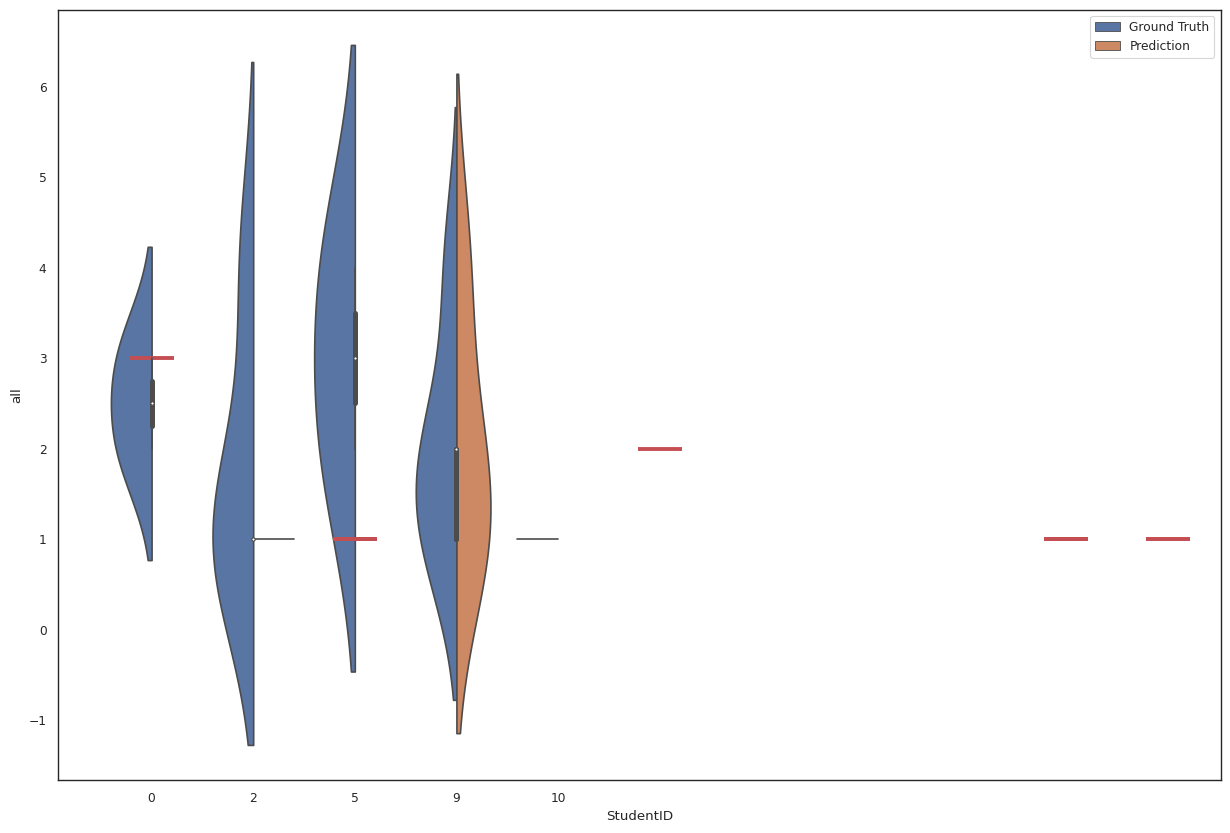

In [224]:
fig, axn = plt.subplots(1,1, figsize= (15,10))
sns.violinplot(data=df_ref_handraise, x='StudentID',y='all', hue='type', split=True, ax = axn)
sns.scatterplot(data=df_ref_handraise, x='StudentID',y='ref', ax = axn, color='#c44e52', marker="_",s=1000)

In [225]:
df_ref_handraise_gt.to_csv(f'CS_1C_across_session_{course}.csv',index=False)

In [75]:
# selected_students = [0,1,2,5,7,8,12,13,15,16,19]
# df_ref_handraise[df_ref_handraise.StudentID.isin(selected_students)].to_csv('CS_1C_dist_across_session.csv', index=False)

In [86]:
# df_session_hand_raises

,session,StudentID,time,sid
0,classinsight-cmu_05748A_ghc_4101_201902051630,0,1,0205_0
1,classinsight-cmu_05748A_ghc_4101_201902051630,1,1,0205_1
2,classinsight-cmu_05748A_ghc_4101_201902051630,2,5,0205_2
3,classinsight-cmu_05748A_ghc_4101_201902051630,4,4,0205_4
4,classinsight-cmu_05748A_ghc_4101_201902051630,5,1,0205_5
...,...,...,...,...
85,classinsight-cmu_05748A_ghc_4101_201904021630,14,14,0402_14
86,classinsight-cmu_05748A_ghc_4101_201904021630,15,6,0402_15
87,classinsight-cmu_05748A_ghc_4101_201904021630,16,7,0402_16
88,classinsight-cmu_05748A_ghc_4101_201904021630,18,5,0402_18
